### Tutorial for training EHR-M-GAN

Reference: "Generating Synthetic Mixed-type Longitudinal Electronic Health Records for Artificial Intelligent". https://arxiv.org/abs/2112.12047

In this work, we propose a generative adversarial network (GAN) entitled EHR-M-GAN which simultaneously synthesizes mixed-type timeseries EHR data (e.g., continuous-valued timeseries and discrete-valued timeseries). EHR-M-GAN is capable of capturing the multidimensional, heterogeneous, and correlated temporal dynamics in patient trajectories.

#### Necessary packages and functions call

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import os
from networks import C_VAE_NET, D_VAE_NET, C_GAN_NET, D_GAN_NET
from m3gan import m3gan
from utils import renormlizer


2023-02-21 17:51:50.371918: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
DATA_PATH = "/root/codebase/dataset"
CODE_PATH = "/root/codebase/jupyter-notebook/"

#### Import dataset
  - MIMIC-III: https://physionet.org/content/mimiciii/1.4/ (used in this tutorial)
  - eICU-CRD: https://physionet.org/content/eicu-crd/2.0/
  - HiRID: https://physionet.org/content/hirid/1.1.1/


In [3]:
# prepare data for training GAN
with open(os.path.join(DATA_PATH, 'vital_sign_24hrs.pkl'), 'rb') as f:
    vital_labs_3D = pickle.load(f)

with open(os.path.join(DATA_PATH, 'med_interv_24hrs.pkl'), 'rb') as f:
    medical_interv_3D = pickle.load(f)

with open(os.path.join(DATA_PATH, 'statics_cond.pkl'), 'rb') as f:
    statics = pickle.load(f)

In [4]:
continuous_x = vital_labs_3D
discrete_x = medical_interv_3D

#### Define network parameters

In [5]:
# timeseries params:
time_steps = continuous_x.shape[1]
c_dim = continuous_x.shape[2]
d_dim = discrete_x.shape[2]
no_gen = continuous_x.shape[0]

In [6]:
# hyper-params for training
batch_size = 256
num_pre_epochs = 300
num_epochs = 500
epoch_ckpt_freq = 100
epoch_loss_freq = 10

In [7]:
# network size
shared_latent_dim = 15
c_z_size = shared_latent_dim
c_noise_dim = int(c_dim/2)
d_z_size = shared_latent_dim
d_noise_dim = int(d_dim/2)

In [8]:
# hyper-params in the networks
d_rounds=1
g_rounds=3
v_rounds=1
v_lr_pre=0.0005
v_lr=0.0001  
g_lr=0.0001
d_lr=0.0001

alpha_re = 1
alpha_kl = 0.5
alpha_mt = 0.05
alpha_ct = 0.05
alpha_sm = 1
c_beta_adv, c_beta_fm = 1, 20
d_beta_adv, d_beta_fm = 1, 10

enc_size=128
dec_size=128
enc_layers=3
dec_layers=3
keep_prob=0.9
l2scale=0.001

gen_num_units=128
gen_num_layers=3
dis_num_units=128
dis_num_layers=1
keep_prob=0.9
l2_scale=0.001

#### Initialize networks
 - Dual-VAE: Including C_VAE_NET and D_VAE_NET;
 - Sequentially coupled GANs: Including C_GAN_NET and D_GAN_NET.

In [9]:
# networks for continuousGAN
c_vae = C_VAE_NET(batch_size=batch_size, time_steps=time_steps, dim=c_dim, z_dim=c_z_size,
                  enc_size=enc_size, dec_size=dec_size, 
                  enc_layers=enc_layers, dec_layers=dec_layers, 
                  keep_prob=keep_prob, l2scale=l2scale)

c_gan = C_GAN_NET(batch_size=batch_size, noise_dim=c_noise_dim, dim=c_dim,
                  gen_num_units=gen_num_units, gen_num_layers=gen_num_layers,
                  dis_num_units=dis_num_units, dis_num_layers=dis_num_layers,
                  keep_prob=keep_prob, l2_scale=l2_scale,
                  gen_dim=c_z_size, time_steps=time_steps)

In [10]:
# networks for discreteGAN
d_vae = D_VAE_NET(batch_size=batch_size, time_steps=time_steps, dim=d_dim, z_dim=d_z_size,
                  enc_size=enc_size, dec_size=dec_size, 
                  enc_layers=enc_layers, dec_layers=dec_layers, 
                  keep_prob=keep_prob, l2scale=l2scale)

d_gan = D_GAN_NET(batch_size=batch_size, noise_dim=d_noise_dim, dim=d_dim,
                  gen_num_units=gen_num_units, gen_num_layers=gen_num_layers,
                  dis_num_units=dis_num_units, dis_num_layers=dis_num_layers,
                  keep_prob=keep_prob, l2_scale=l2_scale,
                  gen_dim=d_z_size, time_steps=time_steps)

In [11]:
# create data directory for saving
checkpoint_dir = os.path.join(CODE_PATH, "data/checkpoint/")  
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


#### Training models
 - Pretraining dual-VAE
 - Jointly training CRN (coupled recurrent networks) and dual-VAEs

2023-02-21 17:51:53.213736: I tensorflow/core/platform/cpu_feature_guard.cc:145] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX
2023-02-21 17:51:53.228644: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2794845000 Hz
2023-02-21 17:51:53.234016: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55cdc35da620 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-02-21 17:51:53.234036: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-02-21 17:51:53.235487: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-21 17:51:53.262406: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1666] Found device 0 with properties: 
name: NVIDIA A40 major: 8 minor: 6 memoryClockRate(GHz): 1.74
pciBusID: 0000:01:00.0
2023-02-21 17:51:53.262481: I tensor



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.






2023-02-21 17:51:53.657163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1206] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-02-21 17:51:53.657219: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1212]      0 
2023-02-21 17:51:53.657227: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1225] 0:   N 
2023-02-21 17:51:53.659138: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1351] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 46501 MB memory) -> physical GPU (device: 0, name: NVIDIA A40, pci bus id: 0000:01:00.0, compute capability: 8.6)
2023-02-21 17:51:53.660920: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55cdd5545cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-21 17:51:53.660932: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6














Start pretraining dual-VAE:


2023-02-21 17:53:39.805803: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


pretraining epoch 000: loss_cvae: 4.470 | loss_dvae: 3.332 | loss_matching: 1.071 | loss_contra: 1.698 
pretraining epoch 010: loss_cvae: 2.855 | loss_dvae: 2.479 | loss_matching: 0.738 | loss_contra: 1.104 
pretraining epoch 020: loss_cvae: 2.421 | loss_dvae: 2.374 | loss_matching: 0.700 | loss_contra: 1.069 
pretraining epoch 030: loss_cvae: 2.349 | loss_dvae: 2.378 | loss_matching: 0.701 | loss_contra: 1.080 
pretraining epoch 040: loss_cvae: 2.212 | loss_dvae: 2.281 | loss_matching: 0.684 | loss_contra: 1.015 
pretraining epoch 050: loss_cvae: 2.140 | loss_dvae: 2.327 | loss_matching: 0.669 | loss_contra: 1.031 
pretraining epoch 060: loss_cvae: 2.018 | loss_dvae: 2.248 | loss_matching: 0.629 | loss_contra: 0.974 
pretraining epoch 070: loss_cvae: 2.012 | loss_dvae: 2.285 | loss_matching: 0.640 | loss_contra: 0.988 
pretraining epoch 080: loss_cvae: 2.064 | loss_dvae: 2.336 | loss_matching: 0.661 | loss_contra: 1.036 
pretraining epoch 090: loss_cvae: 1.967 | loss_dvae: 2.259 | los

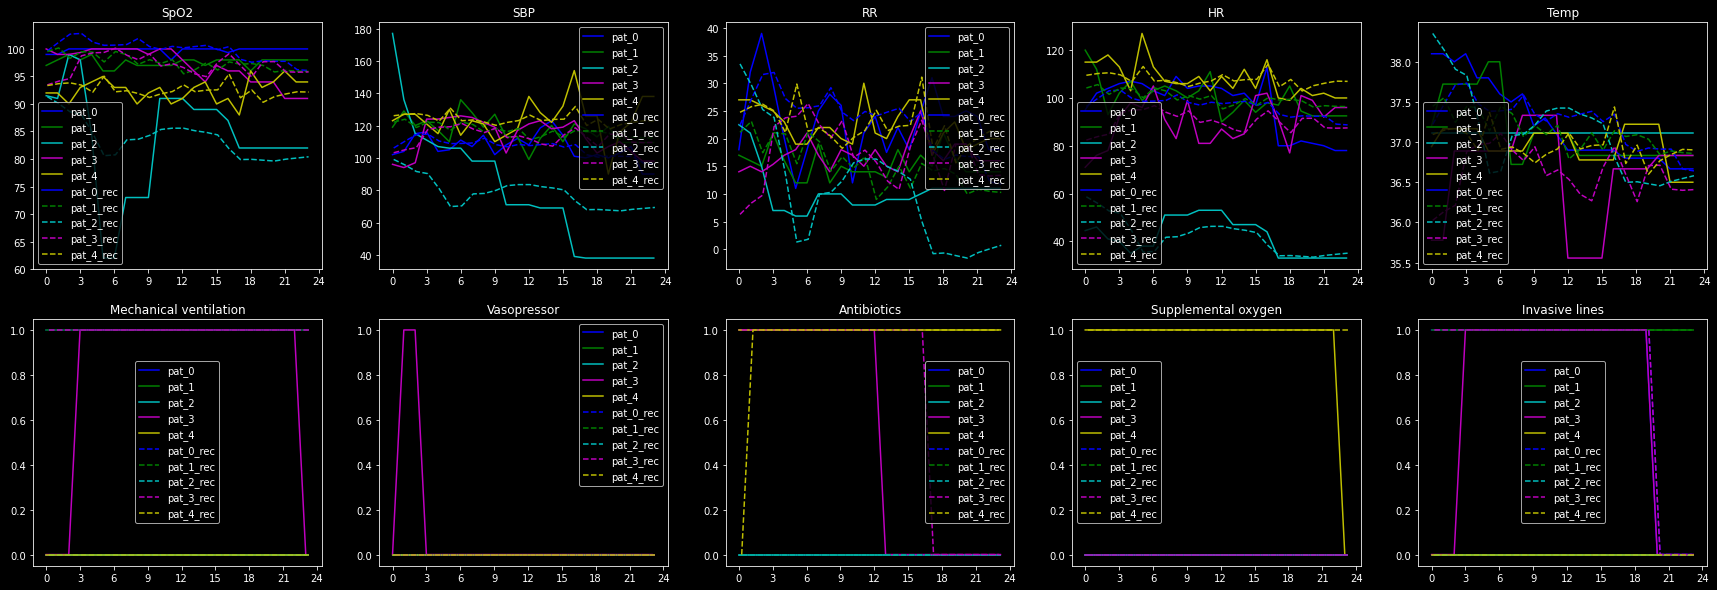

pretraining epoch 100: loss_cvae: 1.960 | loss_dvae: 2.246 | loss_matching: 0.626 | loss_contra: 0.977 
pretraining epoch 110: loss_cvae: 1.965 | loss_dvae: 2.241 | loss_matching: 0.634 | loss_contra: 0.988 
pretraining epoch 120: loss_cvae: 1.972 | loss_dvae: 2.289 | loss_matching: 0.637 | loss_contra: 0.996 
pretraining epoch 130: loss_cvae: 1.976 | loss_dvae: 2.311 | loss_matching: 0.642 | loss_contra: 1.006 
pretraining epoch 140: loss_cvae: 1.979 | loss_dvae: 2.319 | loss_matching: 0.639 | loss_contra: 1.020 
pretraining epoch 150: loss_cvae: 1.920 | loss_dvae: 2.278 | loss_matching: 0.623 | loss_contra: 0.981 
pretraining epoch 160: loss_cvae: 1.958 | loss_dvae: 2.308 | loss_matching: 0.637 | loss_contra: 1.004 
pretraining epoch 170: loss_cvae: 1.953 | loss_dvae: 2.308 | loss_matching: 0.636 | loss_contra: 1.005 
pretraining epoch 180: loss_cvae: 1.902 | loss_dvae: 2.253 | loss_matching: 0.618 | loss_contra: 0.974 
pretraining epoch 190: loss_cvae: 1.871 | loss_dvae: 2.240 | los

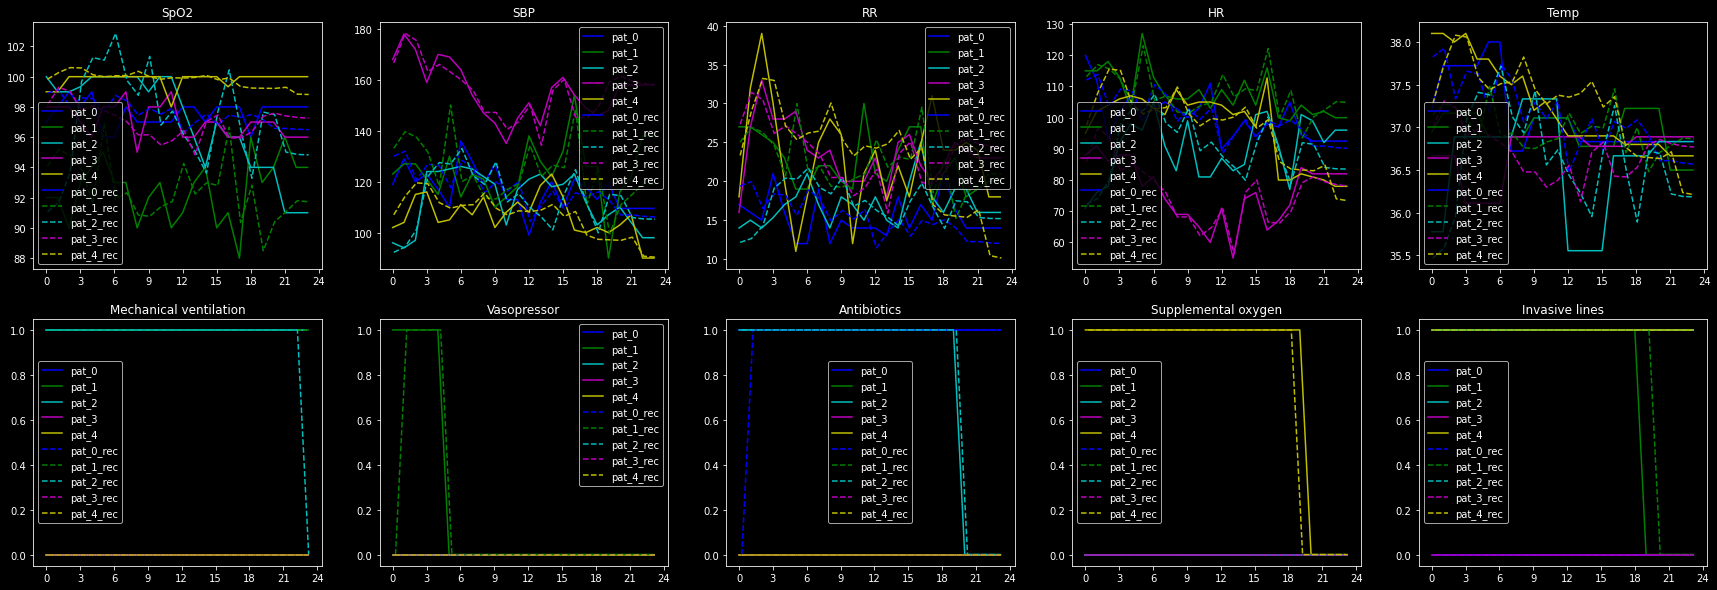

pretraining epoch 200: loss_cvae: 1.964 | loss_dvae: 2.332 | loss_matching: 0.662 | loss_contra: 1.001 
pretraining epoch 210: loss_cvae: 1.908 | loss_dvae: 2.277 | loss_matching: 0.637 | loss_contra: 0.970 
pretraining epoch 220: loss_cvae: 1.912 | loss_dvae: 2.276 | loss_matching: 0.632 | loss_contra: 0.973 
pretraining epoch 230: loss_cvae: 1.921 | loss_dvae: 2.272 | loss_matching: 0.630 | loss_contra: 0.987 
pretraining epoch 240: loss_cvae: 1.898 | loss_dvae: 2.264 | loss_matching: 0.620 | loss_contra: 0.977 
pretraining epoch 250: loss_cvae: 1.896 | loss_dvae: 2.269 | loss_matching: 0.627 | loss_contra: 0.974 
pretraining epoch 260: loss_cvae: 1.871 | loss_dvae: 2.234 | loss_matching: 0.615 | loss_contra: 0.954 
pretraining epoch 270: loss_cvae: 1.918 | loss_dvae: 2.289 | loss_matching: 0.630 | loss_contra: 0.991 
pretraining epoch 280: loss_cvae: 1.851 | loss_dvae: 2.200 | loss_matching: 0.605 | loss_contra: 0.942 
pretraining epoch 290: loss_cvae: 1.883 | loss_dvae: 2.262 | los

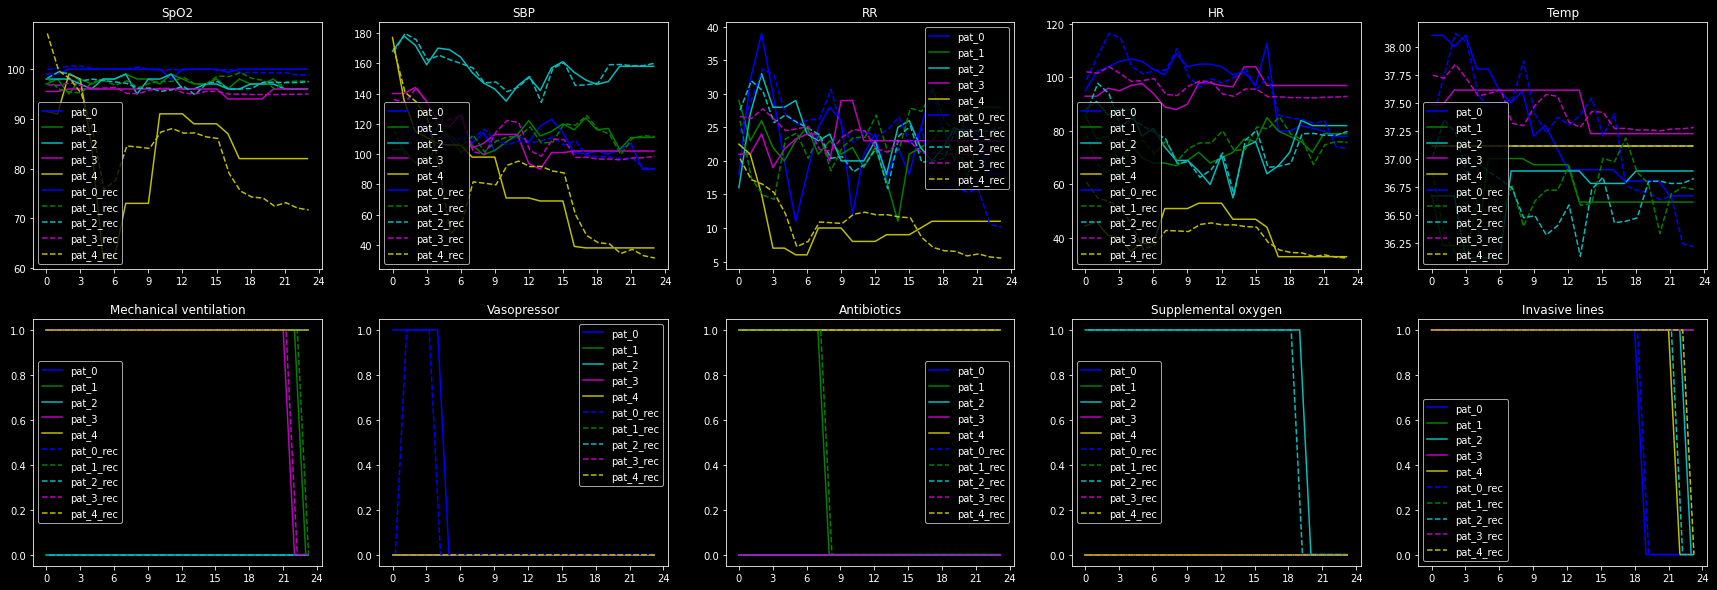

Finish pretraining! Visualize reconstruction errors on validation data:


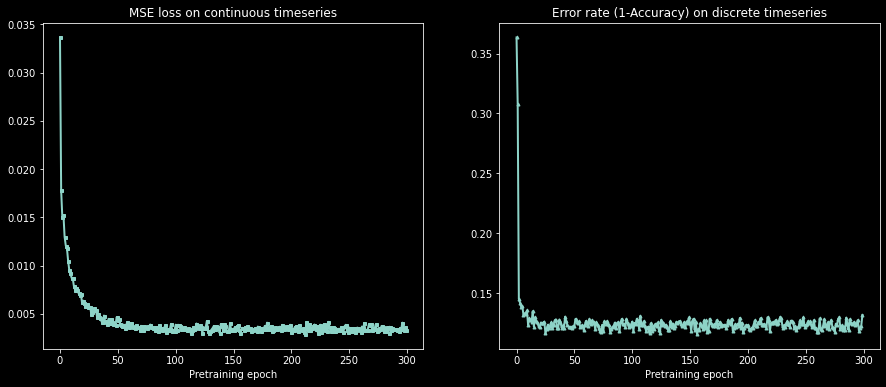

-------------------------------------------------
Start training CRN in EHR-M-GAN: 
training epoch 000: loss_c_disc: 1.364 | loss_c_gen_adv: 0.542 | loss_c_gen_fm: 0.005 | loss_d_disc: 1.380 | loss_d_gen_adv: 0.761 | loss_d_gen_fm: 0.404 
training epoch 010: loss_c_disc: 1.363 | loss_c_gen_adv: 0.553 | loss_c_gen_fm: 0.004 | loss_d_disc: 0.750 | loss_d_gen_adv: 2.287 | loss_d_gen_fm: 0.406 
training epoch 020: loss_c_disc: 1.359 | loss_c_gen_adv: 0.551 | loss_c_gen_fm: 0.007 | loss_d_disc: 0.747 | loss_d_gen_adv: 2.302 | loss_d_gen_fm: 0.416 
training epoch 030: loss_c_disc: 0.880 | loss_c_gen_adv: 1.218 | loss_c_gen_fm: 0.144 | loss_d_disc: 0.746 | loss_d_gen_adv: 2.307 | loss_d_gen_fm: 0.401 
training epoch 040: loss_c_disc: 0.815 | loss_c_gen_adv: 1.334 | loss_c_gen_fm: 0.159 | loss_d_disc: 0.751 | loss_d_gen_adv: 2.313 | loss_d_gen_fm: 0.410 
training epoch 050: loss_c_disc: 0.777 | loss_c_gen_adv: 1.366 | loss_c_gen_fm: 0.173 | loss_d_disc: 0.747 | loss_d_gen_adv: 2.288 | loss_d_g

In [12]:
tf.reset_default_graph()
run_config = tf.ConfigProto()
with tf.Session(config=run_config) as sess:
    model = m3gan(sess=sess,
                  batch_size=batch_size,
                  time_steps=time_steps,
                  num_pre_epochs=num_pre_epochs,
                  num_epochs=num_epochs,
                  checkpoint_dir=checkpoint_dir,
                  epoch_ckpt_freq=epoch_ckpt_freq,
                  epoch_loss_freq=epoch_loss_freq,
                  # params for c
                  c_dim=c_dim, c_noise_dim=c_noise_dim,
                  c_z_size=c_z_size, c_data_sample=continuous_x,
                  c_vae=c_vae, c_gan=c_gan,
                  # params for d
                  d_dim=d_dim, d_noise_dim=d_noise_dim,
                  d_z_size=d_z_size, d_data_sample=discrete_x,
                  d_vae=d_vae, d_gan=d_gan,
                  # params for training
                  d_rounds=d_rounds, g_rounds=g_rounds, v_rounds=v_rounds,
                  v_lr_pre=v_lr_pre, v_lr=v_lr, g_lr=g_lr, d_lr=d_lr,
                  alpha_re=alpha_re, alpha_kl=alpha_kl, alpha_mt=alpha_mt, 
                  alpha_ct=alpha_ct, alpha_sm=alpha_sm,
                  c_beta_adv=c_beta_adv, c_beta_fm=c_beta_fm, 
                  d_beta_adv=d_beta_adv, d_beta_fm=d_beta_fm)
    model.build()
    model.train()
